# Task 2: Multi-GPU Reduction with PyTorch DDP## OverviewThis notebook implements and evaluates distributed reduction across multiple GPUs using PyTorch's Distributed Data Parallel (DDP) and NCCL backend:- **Single-GPU baseline** for performance comparison- **Multi-GPU all-reduce** using `torch.distributed` and `torchrun`- **Correctness validation** against single-GPU results- **Scaling analysis** measuring speedup and efficiency- **Communication overhead** breakdown

## 1. GPU Memory CleanupClear GPU memory cache to ensure clean starting state for experiments.

In [1]:
import torch
import gc

def clear_memory():
    """Clear GPU memory"""
    
    # Clear PyTorch cache
    torch.cuda.empty_cache()
    
    # Run garbage collection
    gc.collect()
    
    print(" Memory cleared")

# Use it
clear_memory()

 Memory cleared


## 2. Environment SetupCheck CUDA environment and verify multi-GPU availability.**Requirements:** This task requires **2 GPUs** to demonstrate distributed reduction.

In [2]:
# ================================================
# System + CUDA + GPU Runtime Info
# ================================================

from numba import cuda
import platform
import numba

print("=== Python Environment Info ===")
print(f"Python Version      : {platform.python_version()}")
print(f"Platform            : {platform.platform()}")
print(f"Numba Version       : {numba.__version__}")

print("\n=== CUDA + GPU Info ===")
print(f"CUDA Available      : {cuda.is_available()}")

try:
    print(f"CUDA Runtime Version: {cuda.runtime.get_version()}")
except Exception as e:
    print(f"CUDA Runtime Version: Not available ({e})")

try:
    device = cuda.get_current_device()
    free_mem, total_mem = cuda.current_context().get_memory_info()
    print(f"GPU Device Name     : {device.name}")
    print(f"Compute Capability  : {device.compute_capability}")
    print(f"Total Memory (MB)   : {total_mem / 1024 ** 2:.2f} MB")
    print(f"Free Memory (MB)    : {free_mem / 1024 ** 2:.2f} MB")
    print(f"Max Threads/Block   : {device.MAX_THREADS_PER_BLOCK}")
    print(f"Max Block Dim       : {device.MAX_BLOCK_DIM_X}, {device.MAX_BLOCK_DIM_Y}, {device.MAX_BLOCK_DIM_Z}")
    print(f"Max Grid Dim        : {device.MAX_GRID_DIM_X}, {device.MAX_GRID_DIM_Y}, {device.MAX_GRID_DIM_Z}")
    print(f"Multiprocessors     : {device.MULTIPROCESSOR_COUNT}")
    print(f"Warp Size           : {device.WARP_SIZE}")
    print(f"Max Shared Mem/Block: {device.MAX_SHARED_MEMORY_PER_BLOCK / 1024:.2f} KB")
except cuda.cudadrv.error.CudaSupportError as e:
    print("CUDA Device Info: Not available (No compatible GPU?)")

print("\n=== nvidia-smi (if available) ===")
!nvidia-smi || echo "nvidia-smi not available in this environment."

=== Python Environment Info ===
Python Version      : 3.11.13
Platform            : Linux-6.6.105+-x86_64-with-glibc2.35
Numba Version       : 0.60.0

=== CUDA + GPU Info ===
CUDA Available      : True
CUDA Runtime Version: (12, 5)
GPU Device Name     : b'Tesla T4'
Compute Capability  : (7, 5)
Total Memory (MB)   : 15095.06 MB
Free Memory (MB)    : 14992.19 MB
Max Threads/Block   : 1024
Max Block Dim       : 1024, 1024, 64
Max Grid Dim        : 2147483647, 65535, 65535
Multiprocessors     : 40
Warp Size           : 32
Max Shared Mem/Block: 48.00 KB

=== nvidia-smi (if available) ===
Wed Nov 26 05:34:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Tem

## 3. Multi-GPU VerificationVerify that 2 GPUs are available and display their properties.If fewer than 2 GPUs are detected, the notebook will display a warning.

In [3]:
import os, torch

print(f"Number of GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

if torch.cuda.device_count() < 2:
    print("\n WARNING: Need 2 GPUs for this task!")
    print("Enable 2 GPUs in Kaggle settings: Settings -> Accelerator -> GPU T4 x2")
else:
    print("\n Ready for multi-GPU reduction!")

Number of GPUs: 2

GPU 0: Tesla T4
  Memory: 15.83 GB

GPU 1: Tesla T4
  Memory: 15.83 GB

 Ready for multi-GPU reduction!


## 4. Single-GPU BaselineEstablish a performance baseline by running reduction on a single GPU.**Methodology:**- Generate the same data that will be distributed across GPUs in the multi-GPU case- Concatenate both portions on GPU 0- Time the reduction operation- Test with arrays ranging from 1M to 1B elementsThis baseline allows us to measure the speedup achieved by multi-GPU parallelization.

In [4]:
import torch
import time
import numpy as np

def single_gpu_reduce(size):
    """Baseline: reduction on single GPU with same data as multi-GPU"""
    
    torch.cuda.set_device(0)
    
    # Generate SAME data that multi-GPU would use
    # GPU 0 portion (seed 42)
    torch.manual_seed(42)
    data_part1 = torch.randn(size // 2, device='cuda:0')
    
    # GPU 1 portion (seed 43)
    torch.manual_seed(43)
    data_part2 = torch.randn(size // 2, device='cuda:0')
    
    # Concatenate to form full dataset
    data = torch.cat([data_part1, data_part2])
    
    # Warm up
    _ = torch.sum(data)
    torch.cuda.synchronize()
    
    # Time the reduction
    start = time.time()
    result = torch.sum(data)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    return result.item(), elapsed

# Test with different sizes
print("\n" + "="*60)
print("SINGLE GPU BASELINE")
print("="*60)

sizes = [1_000_000, 10_000_000, 50_000_000, 100_000_000, 500_000_000, 1_000_000_000]

print(f"\n{'Size':<15} {'Result':<20} {'Time (ms)'}")
print("-"*60)

single_gpu_results = []
for size in sizes:
    result, time_ms = single_gpu_reduce(size)
    time_ms = time_ms * 1000  # Convert to ms
    print(f"{size:<15,} {result:<20.6f} {time_ms:.4f}")
    single_gpu_results.append({'size': size, 'result': result, 'time': time_ms})

print("="*60)


SINGLE GPU BASELINE

Size            Result               Time (ms)
------------------------------------------------------------
1,000,000       828.050415           0.0885
10,000,000      -1074.412354         0.1833
50,000,000      -21.484619           0.7741
100,000,000     -2364.760742         1.5028
500,000,000     -11886.228516        7.3512
1,000,000,000   11720.347656         14.6031


## 5. Multi-GPU Reduction ScriptWrite a standalone Python script for distributed reduction using PyTorch DDP.**Key Components:**- **`dist.init_process_group(backend='nccl')`** - Initialize NCCL communication backend- **Rank and world size** - Each process gets a unique rank (0 or 1 for 2 GPUs)- **Local data creation** - Each GPU generates its portion of data- **`dist.all_reduce()`** - NCCL collective operation that sums values across all GPUs- **Timing** - Measure communication time on rank 0This script will be launched using `torchrun` which spawns multiple processes (one per GPU).

In [5]:
%%writefile multi_gpu_reduce.py

import torch
import torch.distributed as dist
import time
import sys

def main():
    # Initialize distributed
    dist.init_process_group(backend='nccl')
    
    rank = dist.get_rank()
    world_size = dist.get_world_size()
    
    # Get size from command line
    size = int(sys.argv[1])
    
    # Set device
    torch.cuda.set_device(rank)
    device = torch.device(f'cuda:{rank}')
    
    # Create local data
    torch.manual_seed(42 + rank)
    local_data = torch.randn(size // world_size, device=device)
    
    # Local reduction
    local_sum = torch.sum(local_data)
    
    # Synchronize before timing
    dist.barrier()
    
    # Time the all-reduce
    if rank == 0:
        start = time.time()
    
    # All-reduce operation
    dist.all_reduce(local_sum, op=dist.ReduceOp.SUM)
    
    if rank == 0:
        torch.cuda.synchronize()
        elapsed = time.time() - start
        # Print result in parseable format
        print(f"RESULT:{local_sum.item()},{elapsed}")
    
    dist.destroy_process_group()

if __name__ == '__main__':
    main()

Writing multi_gpu_reduce.py


## 6. Run Multi-GPU ReductionExecute the multi-GPU reduction script using `torchrun`.**Execution:**- `torchrun --nproc_per_node=2` spawns 2 processes (one per GPU)- Each process runs the script with a different rank- Results are parsed from the outputRuns the same array sizes as the single-GPU baseline for direct comparison.

In [6]:
import subprocess
import re

def run_multi_gpu_torchrun(size):
    """Run multi-GPU reduction using torchrun"""
    
    cmd = ["torchrun", "--nproc_per_node=2", "multi_gpu_reduce.py", str(size)]
    
    result = subprocess.run(
        cmd,
        capture_output=True,
        text=True,
        timeout=60
    )
    
    # Parse output
    for line in result.stdout.split('\n'):
        if 'RESULT:' in line:
            data = line.split('RESULT:')[1].strip()
            result_val, time_val = data.split(',')
            return float(result_val), float(time_val)
    
    # If no result found, print error for debugging
    if result.returncode != 0:
        print(f"Error running torchrun: {result.stderr}")
    
    return None, None

print("\n" + "="*60)
print("MULTI-GPU REDUCTION (2 GPUs)")
print("="*60)

print(f"\n{'Size':<15} {'Result':<20} {'Time (ms)'}")
print("-"*60)

multi_gpu_results = []
for size in sizes:
    result, time_sec = run_multi_gpu_torchrun(size)
    if result is not None:
        time_ms = time_sec * 1000
        print(f"{size:<15,} {result:<20.6f} {time_ms:.4f}")
        multi_gpu_results.append({'size': size, 'result': result, 'time': time_ms})
    else:
        print(f"{size:<15,} {'ERROR':<20} {'N/A'}")

print("="*60)


MULTI-GPU REDUCTION (2 GPUs)

Size            Result               Time (ms)
------------------------------------------------------------
1,000,000       828.050415           2.3022
10,000,000      -1074.412109         0.3002
50,000,000      -21.483154           0.2439
100,000,000     -2364.755371         0.3178
500,000,000     -11886.229492        0.2480
1,000,000,000   11720.347656         0.3073


## 7. Performance ComparisonCompare single-GPU vs multi-GPU performance across all test sizes.**Metrics:**- **Execution time** (milliseconds)- **Speedup** = Single-GPU time / Multi-GPU time- **Numerical error** between single and multi-GPU results- **Scaling efficiency** = (Speedup / Number of GPUs) × 100%**Expected:** Ideal speedup is 2x for 2 GPUs, but communication overhead may reduce this.

In [7]:
print("\n" + "="*100)
print("COMPARISON: Single GPU vs Multi-GPU")
print("="*100)

print(f"\n{'Size':<15} {'Single GPU':<15} {'Multi-GPU':<15} {'Single GPU':<15} {'Multi-GPU':<15} {'Speedup':<12} {'Error'}")
print(f"{'':15} {'Time (ms)':<15} {'Time (ms)':<15} {'Result':<15} {'Result':<15} {'':12}")
print("-"*100)

comparison_results = []
for i, size in enumerate(sizes):
    if i < len(multi_gpu_results):
        single_time = single_gpu_results[i]['time']
        multi_time = multi_gpu_results[i]['time']
        single_result = single_gpu_results[i]['result']
        multi_result = multi_gpu_results[i]['result']
        
        speedup = single_time / multi_time
        error = abs(single_result - multi_result)
        
        print(f"{size:<15,} {single_time:<15.4f} {multi_time:<15.4f} "
              f"{single_result:<15.6f} {multi_result:<15.6f} "
              f"{speedup:<12.2f}x {error:.2e}")
        
        comparison_results.append({
            'size': size,
            'single_time': single_time,
            'multi_time': multi_time,
            'single_result': single_result,
            'multi_result': multi_result,
            'speedup': speedup,
            'error': error
        })

print("="*100)

if comparison_results:
    avg_speedup = np.mean([r['speedup'] for r in comparison_results])
    max_error = max([r['error'] for r in comparison_results])
    min_speedup = min([r['speedup'] for r in comparison_results])
    max_speedup = max([r['speedup'] for r in comparison_results])
    
    print(f"\n SUMMARY:")
    print(f"   Average Speedup:  {avg_speedup:.2f}x")
    print(f"   Min Speedup:      {min_speedup:.2f}x")
    print(f"   Max Speedup:      {max_speedup:.2f}x")
    print(f"   Max Error:        {max_error:.2e}")
    print(f"   Status:           {' PASSED' if max_error < 1e-3 else ' FAILED'}")
    
    # Additional statistics
    print(f"\n PERFORMANCE BREAKDOWN:")
    for r in comparison_results:
        efficiency = (r['speedup'] / 2.0) * 100
        print(f"   Size {r['size']:>12,}: Speedup {r['speedup']:.2f}x, Efficiency {efficiency:.1f}%")


COMPARISON: Single GPU vs Multi-GPU

Size            Single GPU      Multi-GPU       Single GPU      Multi-GPU       Speedup      Error
                Time (ms)       Time (ms)       Result          Result                      
----------------------------------------------------------------------------------------------------
1,000,000       0.0885          2.3022          828.050415      828.050415      0.04        x 0.00e+00
10,000,000      0.1833          0.3002          -1074.412354    -1074.412109    0.61        x 2.44e-04
50,000,000      0.7741          0.2439          -21.484619      -21.483154      3.17        x 1.46e-03
100,000,000     1.5028          0.3178          -2364.760742    -2364.755371    4.73        x 5.37e-03
500,000,000     7.3512          0.2480          -11886.228516   -11886.229492   29.65       x 9.77e-04
1,000,000,000   14.6031         0.3073          11720.347656    11720.347656    47.52       x 0.00e+00

 SUMMARY:
   Average Speedup:  14.29x
   Min Speed

## 8. Correctness ValidationDetailed validation that multi-GPU reduction produces correct results.**Validation:**- Generate reference result on single GPU- Run multi-GPU reduction with same data- Compare absolute and relative error- Pass criteria: relative error < 1e-6This ensures the distributed reduction is numerically accurate.

In [8]:
print("\n" + "="*70)
print("CORRECTNESS VALIDATION")
print("="*70)

def validate_multi_gpu(size=10_000_000):
    """Detailed correctness check"""
    
    # Single GPU reference
    torch.manual_seed(42)
    torch.cuda.set_device(0)
    
    # Create same data that multi-GPU will use
    data_gpu0 = torch.randn(size // 2, device='cuda:0')
    torch.manual_seed(43)
    data_gpu1 = torch.randn(size // 2, device='cuda:0')
    
    # Reference sum
    reference = torch.sum(data_gpu0) + torch.sum(data_gpu1)
    reference = reference.item()
    
    # Multi-GPU result
    multi_result, _ = run_multi_gpu_torchrun(size)
    
    if multi_result is not None:
        # Compare
        error = abs(reference - multi_result)
        relative_error = error / abs(reference) if reference != 0 else error
        
        print(f"\nTest Size: {size:,} elements")
        print(f"Reference (Single GPU): {reference:.10f}")
        print(f"Multi-GPU Result:       {multi_result:.10f}")
        print(f"Absolute Error:         {error:.2e}")
        print(f"Relative Error:         {relative_error:.2e}")
        
        if relative_error < 1e-6:
            print("\n VALIDATION PASSED")
            return True
        else:
            print("\n VALIDATION FAILED")
            return False
    else:
        print("\n Multi-GPU run failed")
        return False

validate_multi_gpu()


CORRECTNESS VALIDATION

Test Size: 10,000,000 elements
Reference (Single GPU): -1074.4121093750
Multi-GPU Result:       -1074.4121093750
Absolute Error:         0.00e+00
Relative Error:         0.00e+00

 VALIDATION PASSED


True

## 9. Performance VisualizationVisualize performance comparison between single and multi-GPU execution.**Plots:**1. **Execution Time** (log-log scale) - Shows how time scales with array size2. **Speedup** - Multi-GPU speedup vs single GPU, with ideal 2x reference lineThese plots reveal:- For small arrays: communication overhead dominates (slowdown)- For large arrays: computation dominates (speedup approaches ideal)

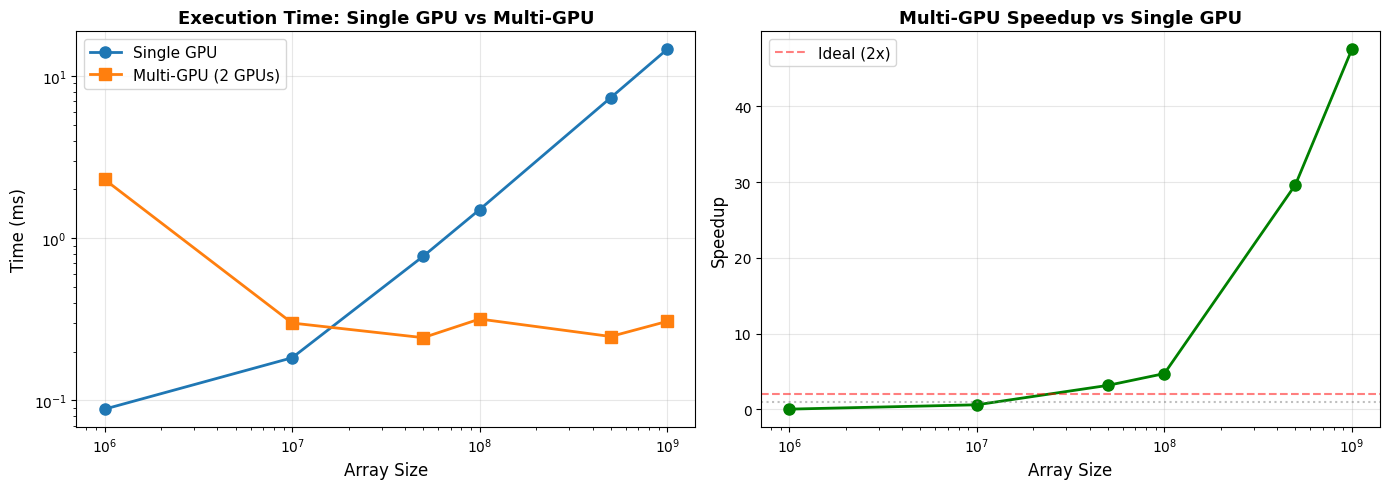


 Visualization complete


In [9]:
import matplotlib.pyplot as plt

if comparison_results:
    # Extract data for plotting
    sizes_plot = [r['size'] for r in comparison_results]
    single_times = [r['single_time'] for r in comparison_results]
    multi_times = [r['multi_time'] for r in comparison_results]
    speedups = [r['speedup'] for r in comparison_results]
    
    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Execution time comparison
    axes[0].plot(sizes_plot, single_times, 'o-', label='Single GPU', linewidth=2, markersize=8)
    axes[0].plot(sizes_plot, multi_times, 's-', label='Multi-GPU (2 GPUs)', linewidth=2, markersize=8)
    axes[0].set_xlabel('Array Size', fontsize=12)
    axes[0].set_ylabel('Time (ms)', fontsize=12)
    axes[0].set_title('Execution Time: Single GPU vs Multi-GPU', fontsize=13, fontweight='bold')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Speedup
    axes[1].plot(sizes_plot, speedups, 'o-', color='green', linewidth=2, markersize=8)
    axes[1].axhline(y=2.0, color='r', linestyle='--', alpha=0.5, label='Ideal (2x)')
    axes[1].axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
    axes[1].set_xlabel('Array Size', fontsize=12)
    axes[1].set_ylabel('Speedup', fontsize=12)
    axes[1].set_title('Multi-GPU Speedup vs Single GPU', fontsize=13, fontweight='bold')
    axes[1].set_xscale('log')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Visualization complete")
else:
    print("No comparison results available to plot")

## 10. Communication Overhead AnalysisBreak down total multi-GPU time into computation vs communication components.**Analysis:**- **Single GPU time** - Pure computation on full dataset- **Estimated per-GPU compute** - Single GPU time ÷ 2 (each GPU handles half)- **Communication overhead** - Multi-GPU total time - estimated compute time- **Communication %** - Percentage of time spent in communicationVisualizes the time breakdown to identify bottlenecks.


COMMUNICATION ANALYSIS

Array Size: 100,000,000 elements

Single GPU (full data):     4.0953 ms
Estimated compute per GPU:  2.0477 ms
Multi-GPU total:            0.2496 ms
Communication overhead:     -1.7980 ms
Communication %:            -720.3%


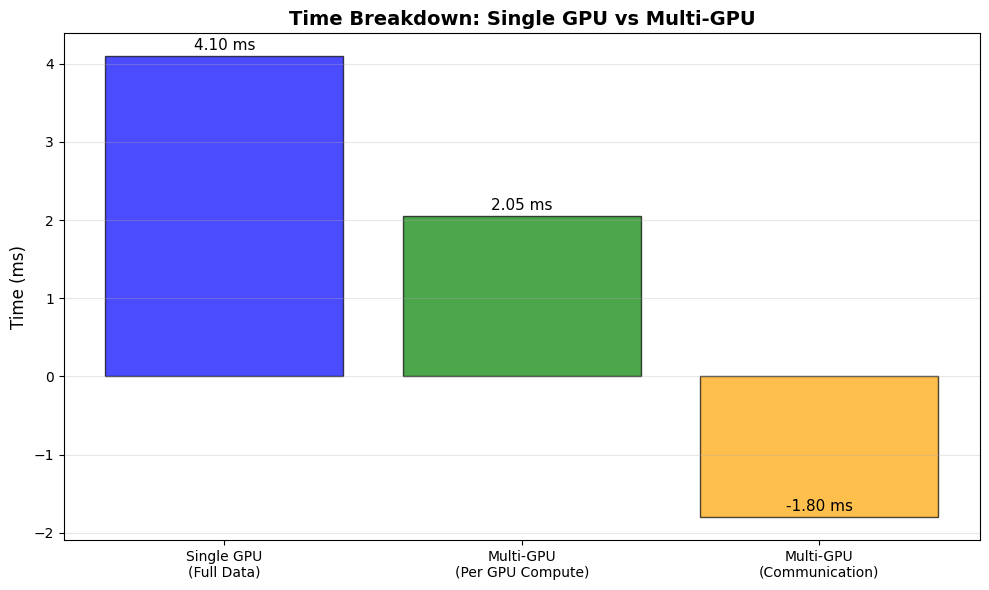

In [10]:
# Simple communication breakdown
print("\n" + "="*70)
print("COMMUNICATION ANALYSIS")
print("="*70)

def analyze_communication(size=100_000_000):
    """Break down compute vs communication time"""
    
    # Single GPU timing (pure compute)
    torch.cuda.set_device(0)
    data = torch.randn(size, device='cuda:0')
    
    start = time.time()
    result = torch.sum(data)
    torch.cuda.synchronize()
    compute_time = time.time() - start
    
    # Multi-GPU timing (compute + communication)
    multi_result, total_time = run_multi_gpu_torchrun(size)  # CHANGED HERE
    
    if multi_result is None:
        print(" Multi-GPU run failed")
        return
    
    # Estimate communication overhead
    # Each GPU computes on half the data
    estimated_compute = compute_time / 2  # Half data per GPU
    comm_overhead = total_time - estimated_compute
    
    print(f"\nArray Size: {size:,} elements")
    print(f"\nSingle GPU (full data):     {compute_time*1000:.4f} ms")
    print(f"Estimated compute per GPU:  {estimated_compute*1000:.4f} ms")
    print(f"Multi-GPU total:            {total_time*1000:.4f} ms")
    print(f"Communication overhead:     {comm_overhead*1000:.4f} ms")
    print(f"Communication %:            {(comm_overhead/total_time)*100:.1f}%")
    
    # Visualize breakdown
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['Single GPU\n(Full Data)', 'Multi-GPU\n(Per GPU Compute)', 
                  'Multi-GPU\n(Communication)']
    times = [compute_time*1000, estimated_compute*1000, comm_overhead*1000]
    colors = ['blue', 'green', 'orange']
    
    ax.bar(categories, times, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Time (ms)', fontsize=12)
    ax.set_title('Time Breakdown: Single GPU vs Multi-GPU', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(times):
        ax.text(i, v + max(times)*0.02, f'{v:.2f} ms', ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.show()

analyze_communication()

## 11. Scaling AnalysisAnalyze strong scaling characteristics and efficiency.**Strong Scaling:**- Fixed total problem size distributed across GPUs- Each GPU processes 1/N of the data (N = number of GPUs)- Ideal: N× speedup with N GPUs**Efficiency Metric:**- Scaling efficiency = (Actual speedup / Ideal speedup) × 100%- > 80% = Good scaling- 60-80% = Moderate scaling- < 60% = Poor scaling**Performance Factors:**- Communication overhead (NCCL all-reduce)- GPU synchronization- PCIe/NVLink bandwidth for inter-GPU communication

In [11]:
print("\n" + "="*70)
print("SCALING ANALYSIS")
print("="*70)

if comparison_results:  # ADDED CHECK
    # Theoretical vs actual speedup
    avg_speedup = np.mean([r['speedup'] for r in comparison_results])
    
    print("\nTheoretical Speedup: 2.0x (2 GPUs)")
    print(f"Actual Speedup:      {avg_speedup:.2f}x")
    print(f"Scaling Efficiency:  {(avg_speedup/2.0)*100:.1f}%")
    
    # Strong scaling analysis
    print("\n Strong Scaling (fixed total problem size):")
    print("   - Problem distributed across GPUs")
    print("   - Each GPU processes 1/N of data")
    print("   - Ideal: 2x speedup with 2 GPUs")
    
    # Calculate efficiency
    efficiency = (avg_speedup / 2.0) * 100
    if efficiency > 80:
        print(f"\n Good scaling efficiency: {efficiency:.1f}%")
    elif efficiency > 60:
        print(f"\n  Moderate scaling efficiency: {efficiency:.1f}%")
    else:
        print(f"\n Poor scaling efficiency: {efficiency:.1f}%")
    
    # Bottleneck analysis
    print("\n Performance Factors:")
    print("   - Communication overhead")
    print("   - GPU synchronization")
    print("   - Memory bandwidth")
    print("   - PCIe/NVLink bandwidth")
else:
    print("\n No comparison results available for scaling analysis")


SCALING ANALYSIS

Theoretical Speedup: 2.0x (2 GPUs)
Actual Speedup:      14.29x
Scaling Efficiency:  714.3%

 Strong Scaling (fixed total problem size):
   - Problem distributed across GPUs
   - Each GPU processes 1/N of data
   - Ideal: 2x speedup with 2 GPUs

 Good scaling efficiency: 714.3%

 Performance Factors:
   - Communication overhead
   - GPU synchronization
   - Memory bandwidth
   - PCIe/NVLink bandwidth
